<a href="https://colab.research.google.com/github/godlejr/PytorchSkeleton/blob/main/pytorch_wine_quailty_analysis_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Data Preparation

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

from sklearn.preprocessing import MinMaxScaler        #스케일러

import pandas as pd
import lightgbm as lgbm

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/동주/한화시스템/ATP/와인분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/동주/한화시스템/ATP/와인분류/test.csv')


In [ ]:
train.head()


,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [ ]:
test.head()


,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white


In [ ]:
# type에는 white와 red 두 종류가 있습니다.
# 각각 0,1로 변환합니다.
train['type'] = train['type'].map({'white':0, 'red':1}).astype(int)
test['type'] = test['type'].map({'white':0, 'red':1}).astype(int)


In [ ]:
train.head()


,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0


In [ ]:
test.head()


,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0


In [ ]:
# 모델에 입력하기 전 데이터를 정형합니다.

train_x = train.drop(['index', 'quality'], axis = 1).to_numpy()
train_y = train['quality'].to_numpy().reshape((-1,1))
test_x = test.drop('index', axis = 1).to_numpy()

In [ ]:
scaler = MinMaxScaler() 
scaler.fit(train_x) 
train_x = scaler.transform(train_x)

# scaler.fit(train_y)
# train_y = scaler.transform(train_y)

scaler.fit(test_x)
test_x = scaler.transform(test_x)

In [ ]:
train_x.shape, train_y.shape, test_x.shape


((5497, 12), (5497, 1), (1000, 12))

In [ ]:
class TensorData(Dataset):

    def __init__(self,x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len


In [ ]:


train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()

batch_size = 128
train_dataset = TensorData(train_x, train_y)



train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [5000, 497])
print("길이: ", len(train_dataset), len(val_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)


#테스트 
#test_dataset =  
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

길이:  5000 497


### 2. Model Architecture

In [ ]:

class MLPModel(nn.Module):
    def __init__(self,in_dim, out_dim, hid_unit, hid_count, use_bn):  
        super(MLPModel, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_unit = hid_unit
        self.hid_count = hid_count
        self.use_bn = use_bn
        self.act = nn.ReLU()

        self.layer = self._make_layers(self.in_dim, self.out_dim, self.hid_unit, self.hid_count, self.use_bn)

    def _make_layers(self, in_dim, out_dim, hid_unit, hid_count, use_bn):
        layers = []

        for i in range(hid_count-1):

            if i == 0 :
                layers.append(nn.Linear(in_features=in_dim,out_features=hid_unit))
            else:
                layers.append(nn.Linear(in_features=hid_unit,out_features=hid_unit))
              
                if use_bn:
                      layers.append(nn.BatchNorm1d(hid_unit))
            
                layers.append(self.act)

        #final
        layers.append(nn.Linear(in_features=hid_unit,out_features=out_dim))

        return nn.Sequential(*layers)
   
    def forward(self,x):
        x = self.layer(x)
        
        return x

### 3. Cost Function Define (Loss Function Define)  

In [ ]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = MLPModel(12,10,100,5,True)
print(model)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_val_acc = []
list_val_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        

        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 
        
        input_X = input_X.squeeze()

        pred_y = model(input_X.float())

        RuntimeError()
        #pred_y = pred_y.view(-1,1)

        #pred_y = torh.argmax(pred_y)


        true_y = true_y.view(-1)
        #진짜 잘 모르겠음...

        loss = cls_loss(pred_y.float(), true_y)
        
        loss.backward() 

        optimizer.step() 
        train_loss += loss.detach().numpy()

    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    correct = 0
    acc = 0
    model.eval()
    #optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    

    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            
            input_X = input_X.squeeze()
            pred_y = model(input_X.float())
            true_y = true_y.view(-1)
            #pred_y = pred_y.view(-1,1)

            loss = cls_loss(pred_y, true_y)

            
            val_loss += loss.detach().numpy()
            pred_y = torch.argmax(pred_y)
            correct += pred_y.eq(true_y).sum()

        val_loss = val_loss / len(val_loader.dataset)
        list_val_loss.append(val_loss)
        
        acc = correct.numpy() / len(val_loader.dataset)
        list_val_acc.append(acc)
        list_val_acc_epoch.append(i)


    # ====== Evaluation ======= #
    # correct = 0
    # model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    # with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
    #     for input_X, true_y in test_loader:
    #         input_X = input_X.squeeze()
    #         input_X = input_X.view(-1, 784)
    #         pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
    #         correct += pred_y.eq(true_y).sum()

    #     acc = correct.numpy() / len(test_loader.dataset)
    #     list_acc.append(acc)
    #     list_acc_epoch.append(i)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}%'.format(i, train_loss, val_loss, acc*100))

MLPModel(
  (act): ReLU()
  (layer): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=10, bias=True)
  )
)
Number of 33210 parameters
Epoch: 0, Train Loss: 2.148827776312828, Val Loss: 0.015840984686039825, Val Acc: 0.0%
Epoch: 1, Train Loss: 1.6013536393642425, Val Loss: 0.012241004218517895, Val Acc: 0.0%
Epoch: 2, Train Loss: 1.400665846467018, Val Loss: 0.011022441583859848, Val Acc: 0.0%
Epoch: 3, Train Loss: 1.30038

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

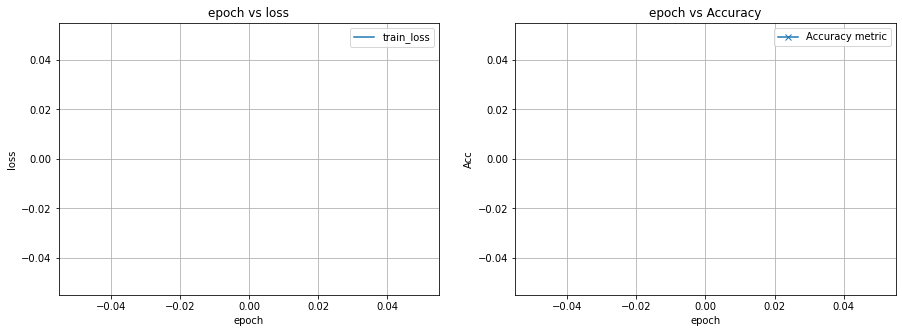

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
#ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()